# Finding the Genre of Movie Plots

## 1. Training and Testing the Model

Loading imports:

In [21]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


#### Read in the training dataset

In [22]:
df = pd.read_csv('train.txt', sep='\t', names=['title', 'language', 'genre', 'director', 'plot'])
df

,title,language,genre,director,plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...
...,...,...,...,...,...
8036,Sa 'Yo Lamang,Filipino,drama,Laurice Guillen,Dianne seems to have a happy family. She and h...
8037,The Lemon Sisters,American,drama,Joyce Chopra,Three lifelong friends work the bars in 1980's...
8038,Dil Ne Phir Yaad Kiya,Bollywood,romance,Unknown,"City-based Ashok, who works as a Salesman in a..."
8039,Rehnaa Hai Terre Dil Mein,Bollywood,romance,Gautham Menon,The story starts with narration by Maddy (R. M...


#### Apply preprocessing
Preprocessing is done on the entire dataset before splitting it into training and test sets by applying lower-casing.

In [23]:
def preprocess_text(text):
    return text.lower()

In [24]:
df['cleaned_plot'] = df['plot'].apply(preprocess_text)
df['augmented_plot'] = df['cleaned_plot'] + ' [LANGUAGE] ' + df['language'] + ' [DIRECTOR] ' + df['director'] + ' [TITLE] ' + df['title']

#### Encode the labels

In [25]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['genre'])
# df[['label', 'genre']].head(10)
dict(enumerate(label_encoder.classes_))


{0: 'action',
 1: 'animation',
 2: 'comedy',
 3: 'crime',
 4: 'drama',
 5: 'horror',
 6: 'romance',
 7: 'sci-fi',
 8: 'western'}

#### Tokenize the dataset

In [26]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [27]:
max_length = 128 
inputs = tokenizer(df['augmented_plot'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=max_length)

#### Split the dataset into training and test data
We use a split of 80\% training and 20\% testing.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(inputs['input_ids'], df['label'], test_size=0.2, random_state=42)
attention_mask_train, attention_mask_test = train_test_split(inputs['attention_mask'], test_size=0.2, random_state=42)

#### Load the pretrained DistilBert model

In [29]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create the dataset objects for training and testing

In [30]:
train_dataset = TensorDataset(X_train, attention_mask_train, torch.tensor(y_train.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [31]:
test_dataset = TensorDataset(X_test, attention_mask_test, torch.tensor(y_test.values, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Define paramters for training

In [32]:
epochs = 4  # Try increasing this to 6 or 8
learning_rate = 3e-5  # Adjust this value down

#### Setting up an optimizer and scheduler
* AdamW: This is a variation of the Adam optimizer that includes weight decay. Weight decay is a form of regularization that helps prevent overfitting by penalizing large weights. The AdamW optimizer is particularly well-suited for training transformer models.
*  Scheduler: It adjusts the learning rate during training. Specifically, this schedule increases the learning rate linearly from zero to the initial learning rate during the warmup phase, and then decreases it linearly after the warmup phase until training ends.  This helps the model converge better, as the learning rate becomes smaller as the model gets closer to optimal parameters.

In [33]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

/Users/joshuaredelbach/Documents/Studium/Master_LuRI/3_Semester/Natural_Language/playground/venv_nlp_project/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Perform training

In [34]:
for epoch in range(epochs):
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_loader):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and learning rate
        optimizer.step()
        scheduler.step()
    
    print(f'Epoch {epoch+1} / {epochs}, Loss: {total_loss / len(train_loader)}')

Epoch 1 / 4, Loss: 1.3185967608767362
Epoch 2 / 4, Loss: 0.8061798857663994
Epoch 3 / 4, Loss: 0.5357003817288437
Epoch 4 / 4, Loss: 0.35425600852465156


Switching model to evaluation mode.

In [35]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### Apply TF-IDF (Term Frequency-Inverse Document Frequency) for Vectorization on the Plot

In [36]:
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(df['cleaned_plot'])

#### Split the TF-IDF vectors in training and test data

In [37]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, train_indices, test_indices = train_test_split(
    X_tfidf, df['label'], df.index, test_size=0.2, random_state=42
)

#### Setting up and training a Support Vector Classifier (SVC) 

In [38]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

#### Let DistilBert and the SVC classify the test data

In [39]:
def distilbert_predict_proba(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

In [40]:
bert_probs = distilbert_predict_proba(df['augmented_plot'].iloc[test_indices].tolist())
svm_probs = svm.predict_proba(X_test_tfidf)

#### Average over the label probabilites of both models

In [41]:
final_probs = (bert_probs + svm_probs) / 2
final_predictions = np.argmax(final_probs, axis=1)

#### Evaluation

In [42]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

precision_per_class = precision_score(y_test_tfidf, final_predictions, average=None)
print(f'Precision per class: {precision_per_class}\n')

recall_per_class = recall_score(y_test_tfidf, final_predictions, average=None)
print(f'Recall per class: {recall_per_class}\n')

f1_per_class = f1_score(y_test_tfidf, final_predictions, average=None)
print(f'F1 score per class: {f1_per_class}\n')

accuracy = accuracy_score(y_test_tfidf, final_predictions)
print(f"Test Accuracy: {accuracy}\n")

Precision per class: [0.66820276 0.82857143 0.68023256 0.76404494 0.59287532 0.78600823
 0.65853659 0.61290323 0.93333333]

Recall per class: [0.71782178 0.75652174 0.52466368 0.62962963 0.73040752 0.85650224
 0.58064516 0.48717949 0.93814433]

F1 score per class: [0.69212411 0.79090909 0.59240506 0.69035533 0.65449438 0.81974249
 0.61714286 0.54285714 0.93573265]

Test Accuracy: 0.7147296457426974



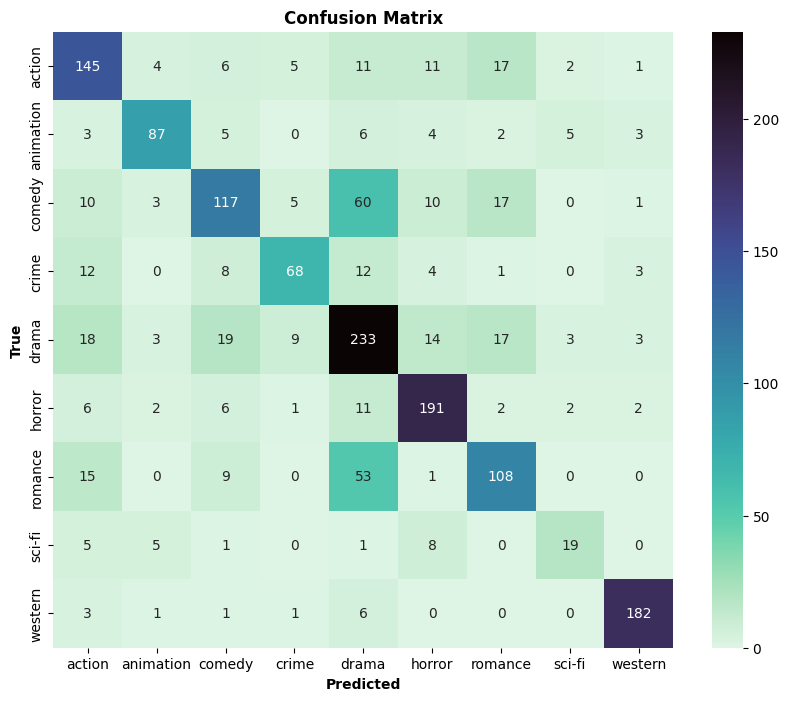

In [43]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_tfidf, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako_r', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted',  fontweight="bold",)
plt.ylabel('True', fontweight="bold")
plt.title('Confusion Matrix', fontweight="bold")
plt.show()

## 2. Prediction for the unlabeled data

In [44]:
df = pd.read_csv('test_no_labels.txt', sep='\t', names=['title', 'language', 'director', 'plot'])
df

,title,language,director,plot
0,Bava Nachadu,Telugu,KS Ravikumar,Ajay (Nagarjuna Akkineni) is an adman (directo...
1,Quick,South_Korean,Unknown,"Seoul, 2004. A group of bikers are joy-riding ..."
2,Doraemon: Nobita's Great Battle of the Mermaid...,Japanese,Unknown,"The film opens with a sunken ship, in which a ..."
3,Little School Mouse,American,Hanna-Barbera,Jerry decides to school Tuffy in the basics of...
4,The Little Damozel,British,Herbert Wilcox,Gambler Recky Poole (James Rennie) accepts a b...
...,...,...,...,...
395,Space Chimps,American,Kirk De Micco,"Ham III, grandson of the first chimpanzee in s..."
396,Rajnigandha,Bollywood,Basu Chatterjee,Deepa (Vidya Sinha) is a graduate student in D...
397,Never Said Goodbye,Chinese,Lin Yu-hsien,"A heart-breaking romantic tale, which starts w..."
398,Sweeney 2,British,Tom Clegg,"A group of particularly violent armed robbers,..."


In [45]:
df['cleaned_plot'] = df['plot'].apply(preprocess_text)
df['augmented_plot'] = df['cleaned_plot'] + ' [LANGUAGE] ' + df['language'] + ' [DIRECTOR] ' + df['director'] + ' [TITLE] ' + df['title']

In [46]:
inputs = tokenizer(df['augmented_plot'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=max_length)

In [47]:
X_tfidf = tfidf.fit_transform(df['cleaned_plot'])

In [48]:
bert_probs = distilbert_predict_proba(df['augmented_plot'].tolist())
svm_probs = svm.predict_proba(X_tfidf)

In [49]:
final_probs_eval = (bert_probs + svm_probs) / 2
final_predictions_eval = np.argmax(final_probs_eval, axis=1)

In [53]:
filename = 'results.txt'

predicted_genres = label_encoder.inverse_transform(final_predictions_eval)

with open(filename, 'w') as file:
    for genre in predicted_genres:
        file.write(f"{genre}\n")
